In [1]:
%matplotlib inline
#%matplotlib notebook

In [2]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

In [3]:
inputs = [
    ["Experiment_Tube_001_001.fcs",1e-12, 0],
    ["Experiment_Tube_002_002.fcs",1e-10, 0],
    ["Experiment_Tube_003_003.fcs",1e-8, 0],
    ["Experiment_Tube_004_004.fcs",1e-6, 0],
    ["Experiment_Tube_005_005.fcs",1e-4, 0],
    ["Experiment_Tube_006_006.fcs",1e-12, 2e-4],
    ["Experiment_Tube_007_007.fcs",1e-10, 2e-4],
    ["Experiment_Tube_008_008.fcs",1e-8, 2e-4],
    ["Experiment_Tube_009_009.fcs",1e-6, 2e-4],
    ["Experiment_Tube_010_010.fcs",1e-4, 2e-4],
    ["Experiment_Tube_011_011.fcs",1e-12, 1e-3],
    ["Experiment_Tube_012_012.fcs",1e-10, 1e-3],
    ["Experiment_Tube_013_013.fcs",1e-8, 1e-3],
    ["Experiment_Tube_014_014.fcs",1e-6, 1e-3],
    ["Experiment_Tube_015_015.fcs",1e-4, 1e-3],
]
in2 = [["Experiment_Tube_016_016.fcs",1e-4, 2e-4,1,30],
       ["Experiment_Tube_017_017.fcs",1e-6, 1e-3,1,30],
       ["Experiment_Tube_018_018.fcs",1e-4, 1e-3,2,20],
       ["Experiment_Tube_010_010.fcs",1e-4, 2e-4,2,30],
       ["Experiment_Tube_014_014.fcs",1e-6, 1e-3,2,30],
       ["Experiment_Tube_015_015.fcs",1e-4, 1e-3,2,30]
]
       
tubes = []
for filename, ahl, iptg in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float'},
                   tubes = tubes).apply()
       
tubes2 = []
for filename, ahl, iptg, pfa, time in in2:
    tubes2.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg, 'PFA' : pfa, 'Minutes' : time}))
    
ex2 = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float', 'PFA' : 'int', 'Minutes' : 'int'},
                   tubes = tubes2).apply()

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10


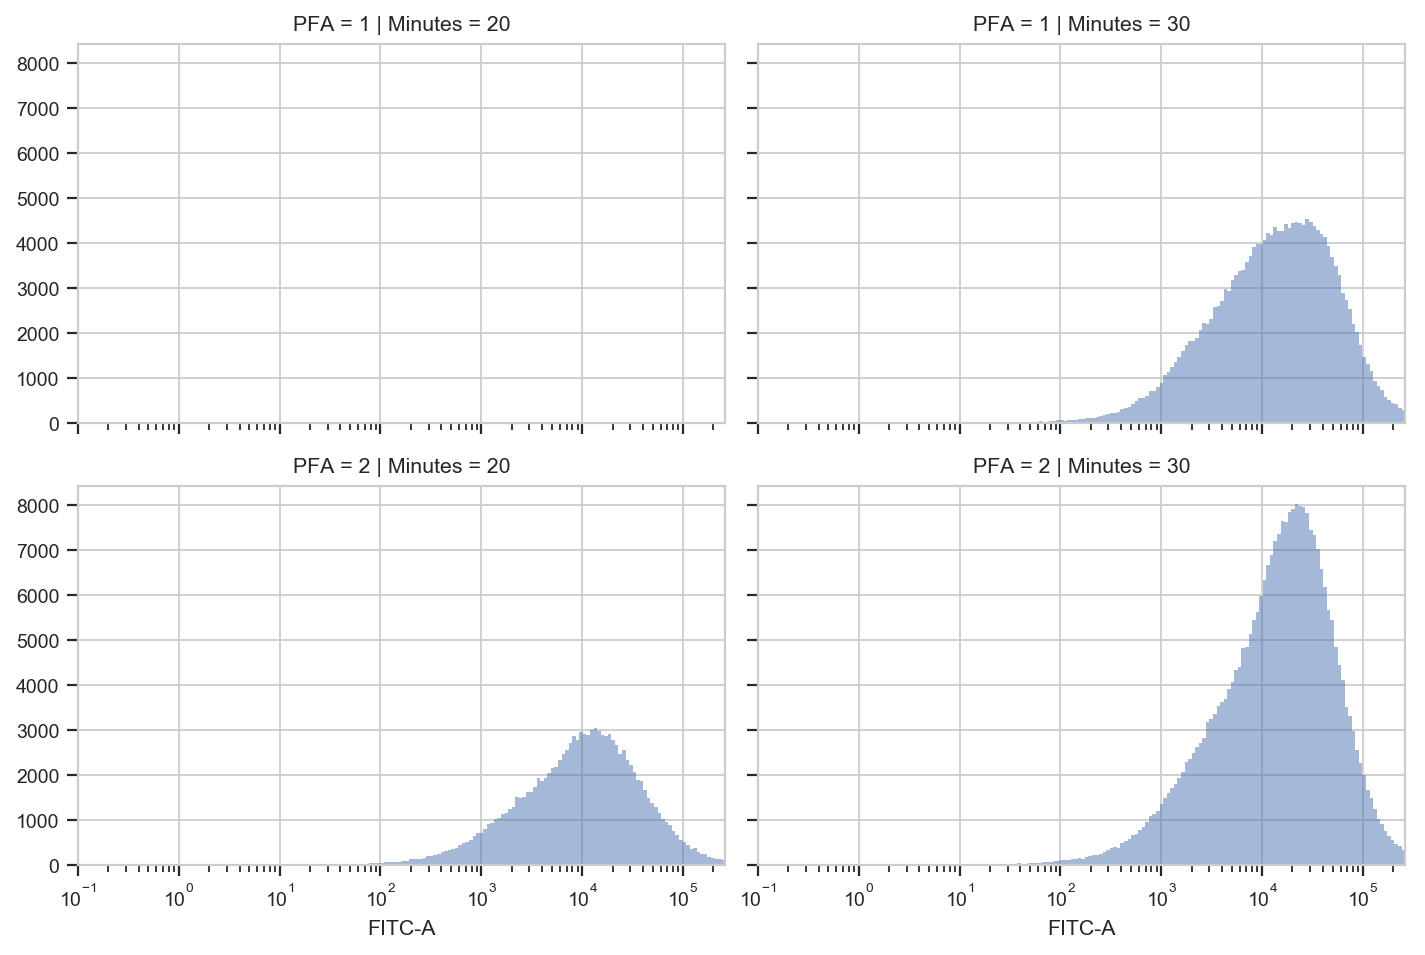

In [4]:
flow.HistogramView(channel = "FITC-A",
                   xfacet = "Minutes",
                   yfacet = "PFA",
                   scale='log').plot(ex2)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


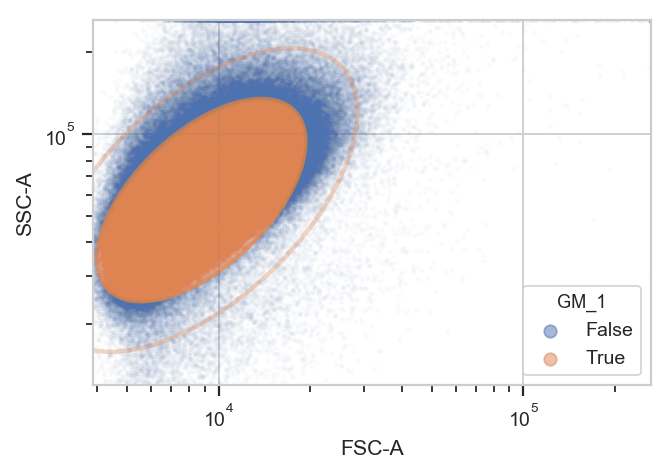

In [5]:
gm2 = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm2.estimate(ex2)
ex_gm2 = gm2.apply(ex2)
gm2.default_view().plot(ex_gm2, alpha = 0.02)

## Effect of fixation time on mNG intensity

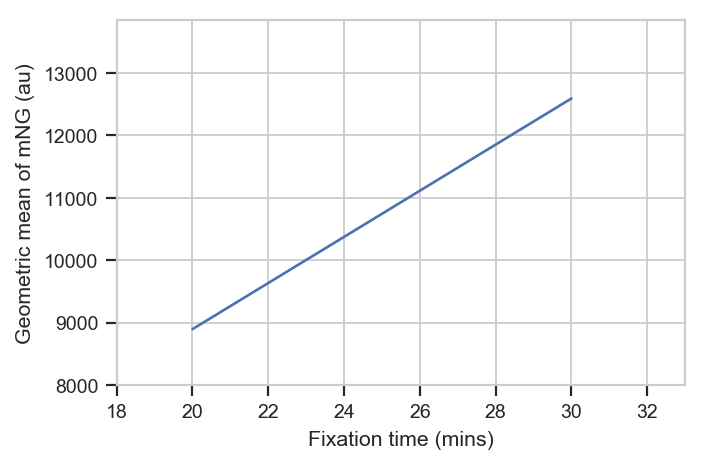

In [6]:
ex3 = flow.ChannelStatisticOp(name = "ByMins",
                              channel = "FITC-A",
                              by = ["Minutes"],
                              function = flow.geom_mean).apply(ex_gm2)
flow.Stats1DView(statistic = ("ByMins", "geom_mean"),
                 scale = "linear",
                 variable = "Minutes",
                 variable_scale = "linear").plot(ex3,ylabel = 'Geometric mean of mNG (au)',xlabel ='Fixation time (mins)')

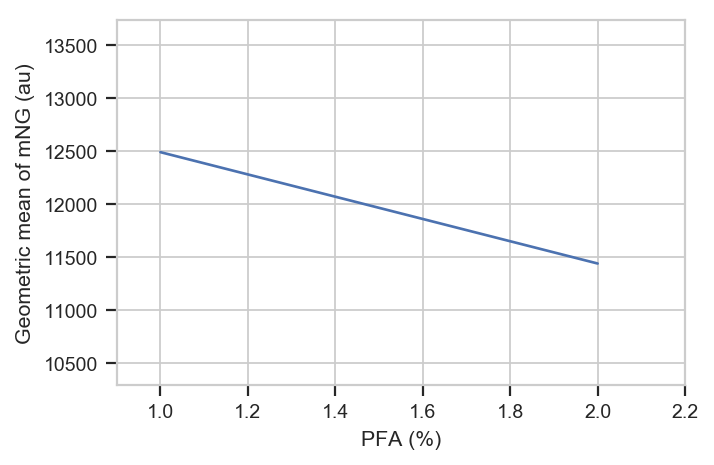

In [7]:
ex3 = flow.ChannelStatisticOp(name = "ByPFA",
                              channel = "FITC-A",
                              by = ["PFA"],
                              function = flow.geom_mean).apply(ex_gm2)
flow.Stats1DView(statistic = ("ByPFA", "geom_mean"),
                 scale = "linear",
                 variable = "PFA",
                 variable_scale = "linear").plot(ex3,ylabel = 'Geometric mean of mNG (au)',xlabel ='PFA (%)')

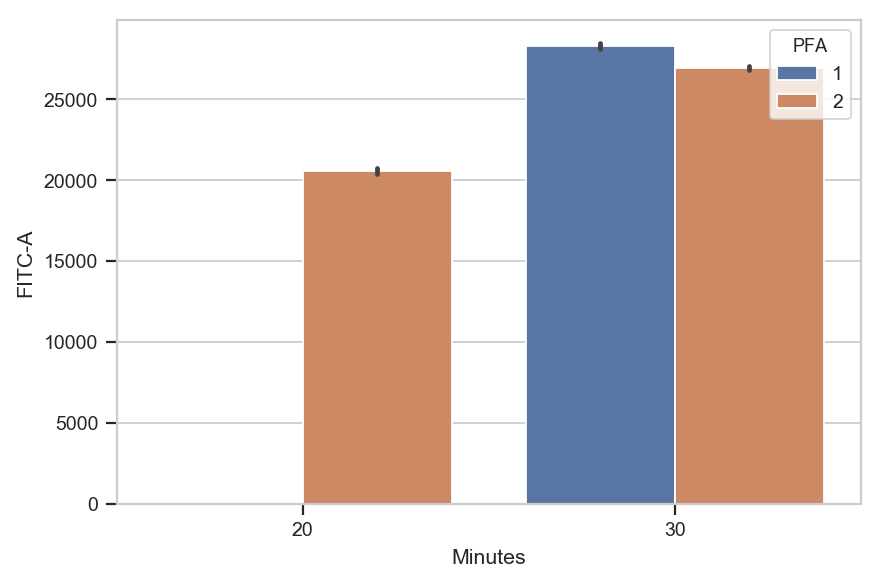

In [8]:
df = ex_gm2.data
sns.barplot(x='Minutes', y='FITC-A',hue='PFA',data=df)

In [9]:
flow.set_default_scale("log")

# Plot FITC-A histograms for all IPTG and AHL induction conditions

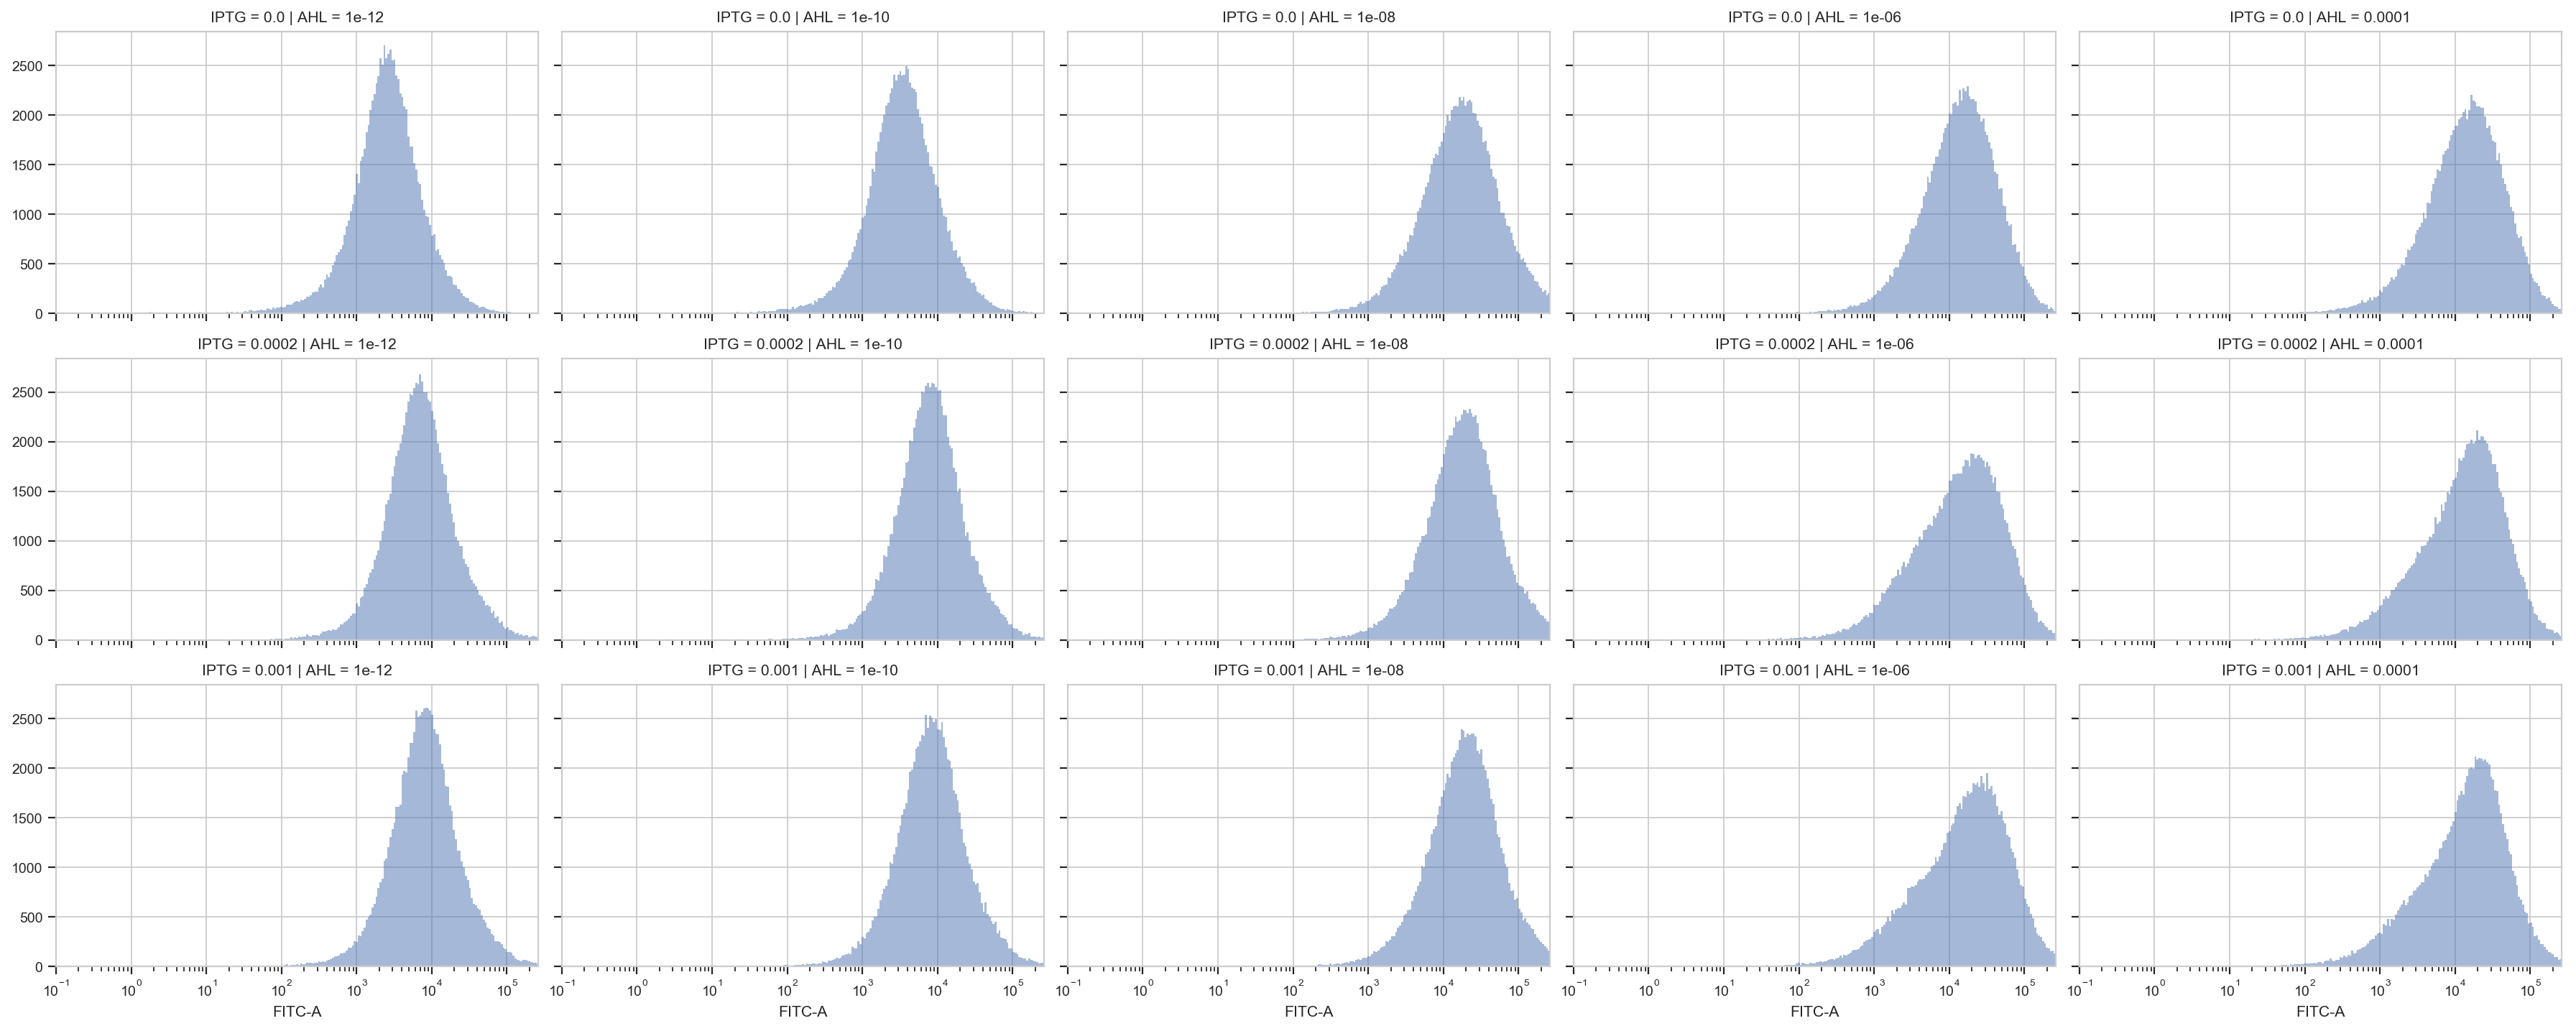

In [10]:

flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

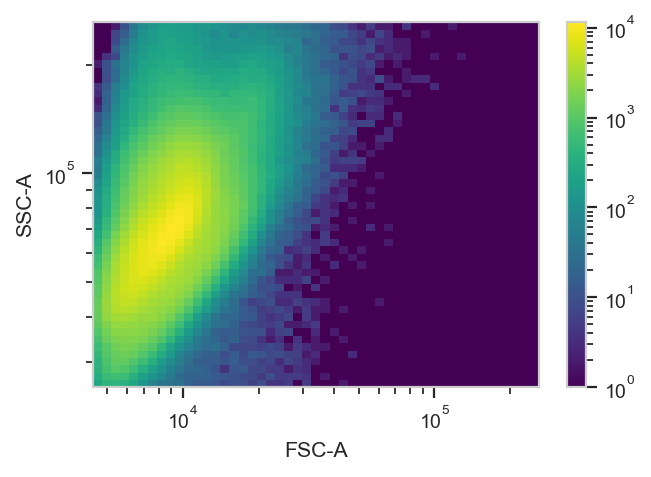

In [11]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

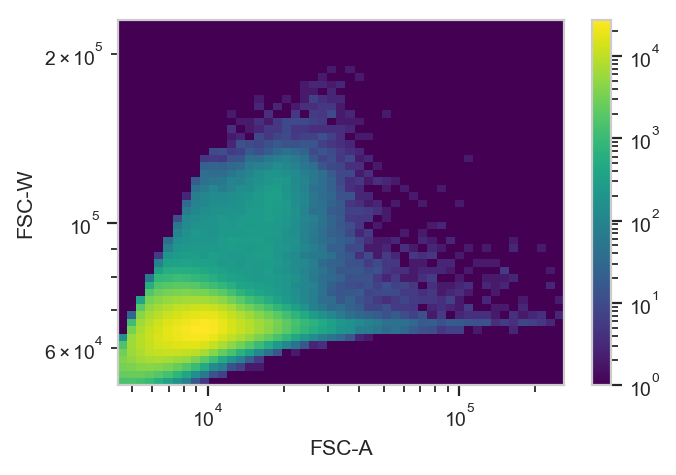

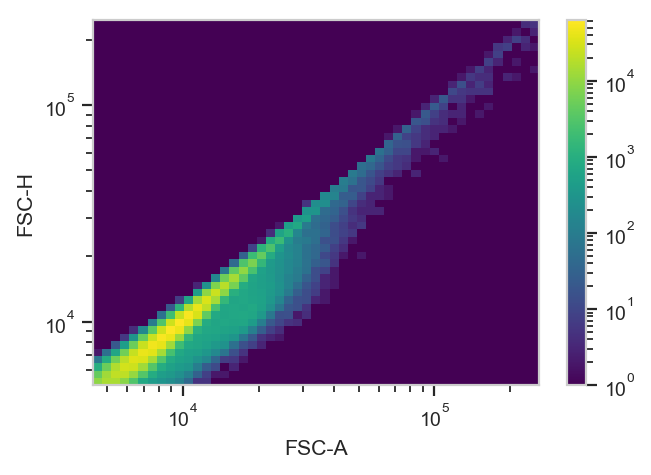

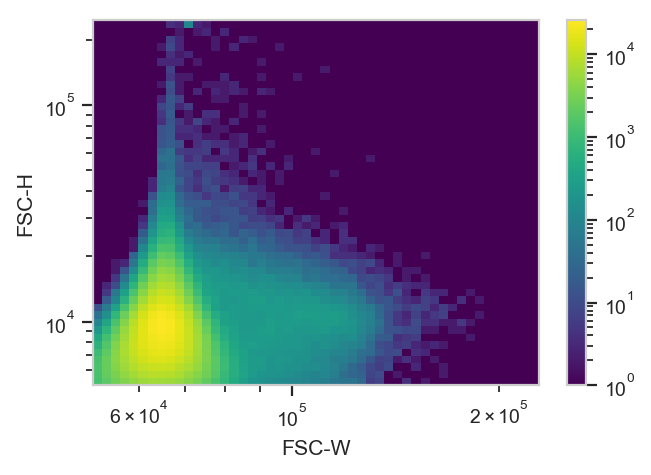

In [12]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


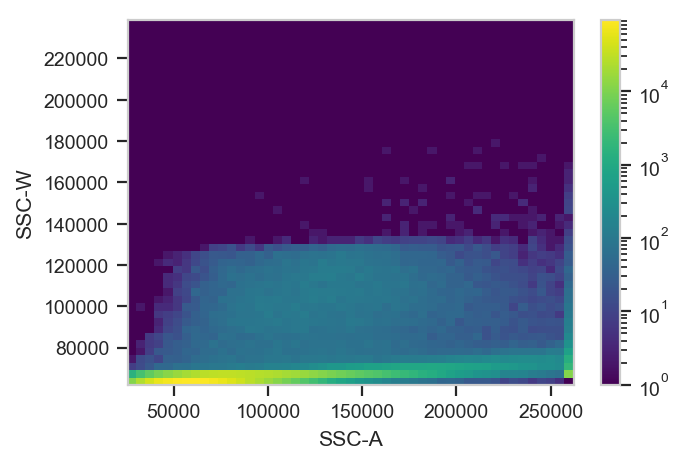

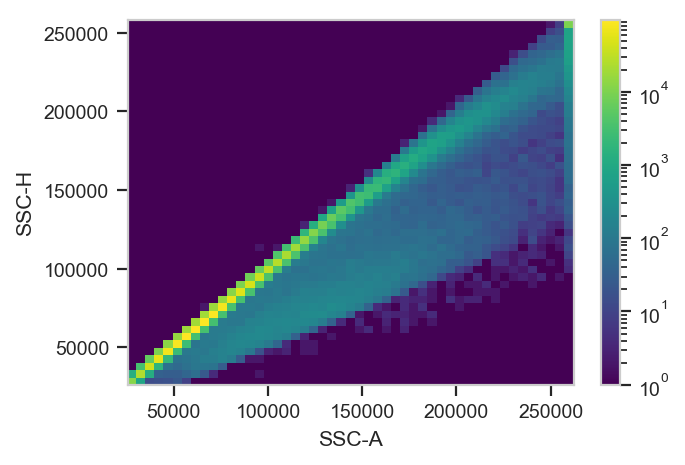

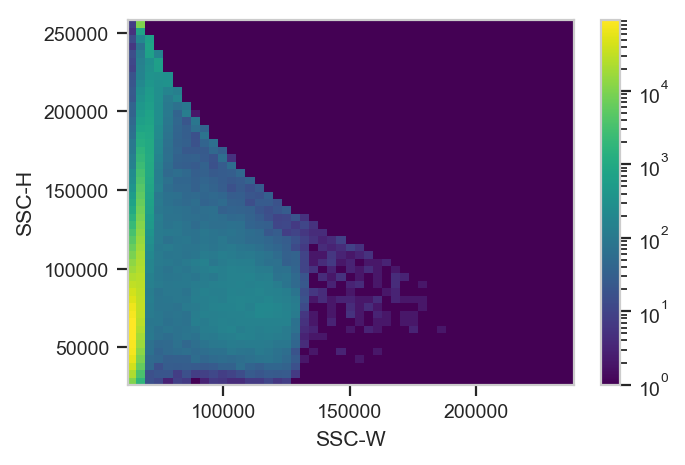

In [13]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

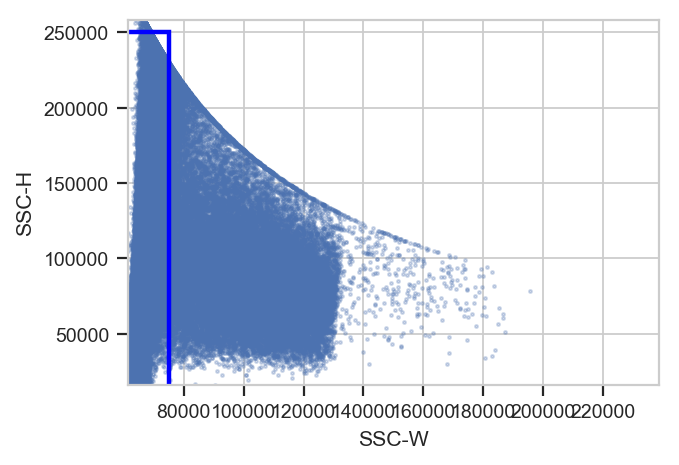

In [14]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 75000,
                   ychannel = "SSC-H",
                   ylow = 5000,
                   yhigh = 250000)
                   
rv = r.default_view(xscale ='linear',yscale='linear')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


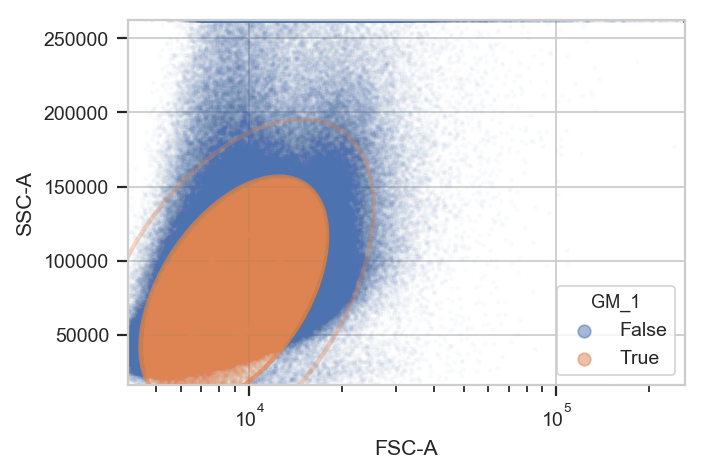

In [15]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'linear'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\utility\log_scale.py:117: RuntimeWarning: invalid value encountered in log10
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\gaussian.py:529: RuntimeWarning: invalid value encountered in less_equal
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\cytoflow\operations\base_op_views.py:342: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


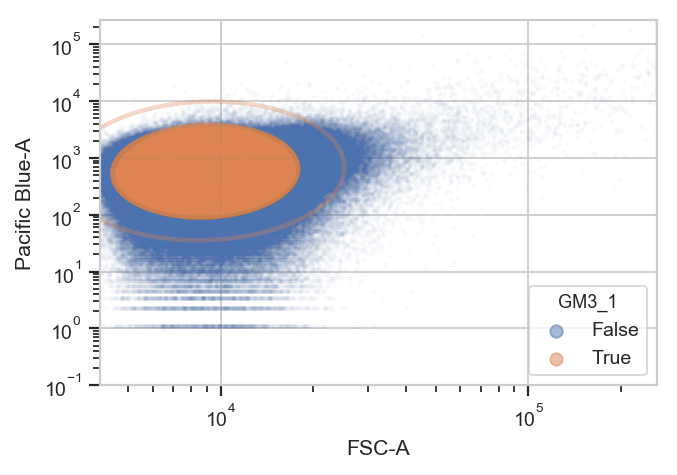

In [16]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [17]:
df =ex_gm2.data

# filter out events that don't fall within the gates

In [18]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,IPTG,Pacific Blue-A,Pacific Blue-H,Pacific Blue-W,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
0,1.000000e-12,8499.500000,10915.0,51032.820312,10599.020508,10599.0,65536.125000,0.000,1100.959961,550.0,131186.390625,67118.460938,66755.0,65892.828125,42.000000,True,True,True
2,1.000000e-12,1958.890015,1363.0,94187.679688,8723.120117,9271.0,61663.082031,0.000,1626.239990,1922.0,55451.230469,79256.281250,77847.0,66722.414062,42.000000,True,True,True
3,1.000000e-12,1375.049927,2249.0,40069.046875,11262.060547,11901.0,62017.511719,0.000,1554.560059,1950.0,52245.972656,120648.398438,118937.0,66479.007812,42.000000,True,True,True
4,1.000000e-12,3916.889893,4566.0,56219.296875,12477.879883,12674.0,64521.886719,0.000,2541.280029,2871.0,58009.523438,137701.687500,135110.0,66793.109375,42.099998,True,True,True
5,1.000000e-12,1726.599976,996.0,113608.898438,12773.140625,13296.0,62958.828125,0.000,667.520020,492.0,88915.843750,63141.937500,63712.0,64949.621094,42.099998,True,True,True
6,1.000000e-12,1974.020020,2837.0,45600.773438,6702.180176,6785.0,64736.046875,0.000,1060.640015,1330.0,52263.234375,52530.468750,52997.0,64959.089844,42.099998,True,True,True
9,1.000000e-12,12415.500000,12390.0,65670.882812,8473.740234,8130.0,68306.898438,0.000,725.760010,663.0,71739.679688,69179.695312,69990.0,64777.265625,42.099998,True,True,True
10,1.000000e-12,1194.380005,1256.0,62320.769531,9504.560547,10620.0,58652.625000,0.000,1750.560059,1499.0,76534.156250,61147.449219,63352.0,63255.453125,42.099998,True,True,True
11,1.000000e-12,2710.050049,2949.0,60225.785156,8048.979980,7793.0,67688.695312,0.000,380.799988,822.0,30360.230469,35649.839844,35697.0,65449.417969,42.099998,True,True,True
12,1.000000e-12,9906.589844,11294.0,57485.238281,5999.180176,6634.0,59264.734375,0.000,769.440002,941.0,53587.699219,54746.570312,52718.0,68057.804688,42.099998,True,True,True


In [19]:
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import numpy as np

def geom_sd(a):
    a = np.array(a)
    u = gmean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
    
    return np.exp(np.std(np.log(a)))
def geom_sem(a):
    a = np.array(a)
    u = geom_mean(a)
    a[a <= 0] = np.abs(a[a <= 0]) + 2 * u
def geom_std(values):
    """
    Calculates the geometric standard deviation for the passed values.
    Source: https://en.wikipedia.org/wiki/Geometric_standard_deviation
    """

   # gmean = stats.gmean(values)
    return sp.exp(sp.sqrt(sp.sum([sp.log(x / gmean(values)) ** 2 for x in values]) / len(values))) 


# Plot mean FITC-A

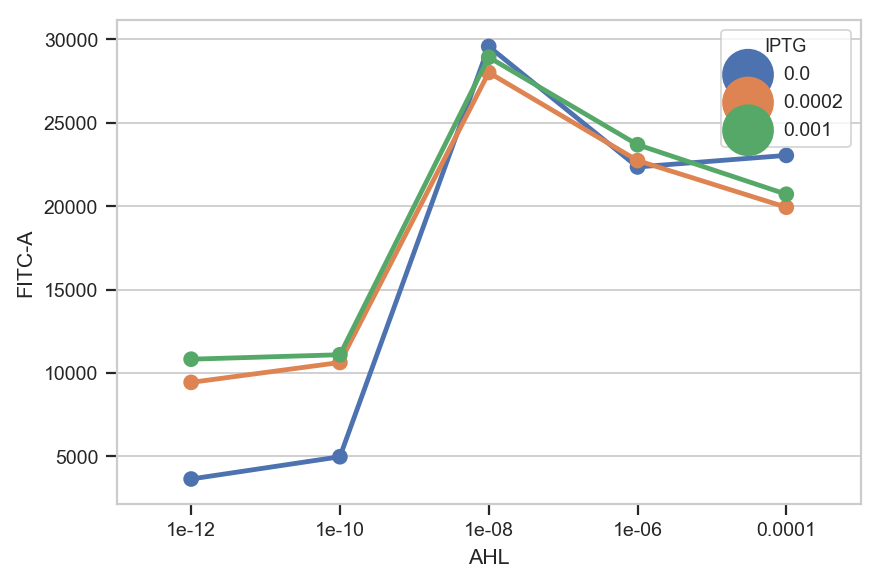

In [20]:
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=df)

In [21]:
gb = df.groupby(['AHL','IPTG'])
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
geostd = df.groupby(['AHL','IPTG'])['FITC-A'].apply(geom_sd).reset_index()

std = df.groupby(['AHL','IPTG'])['FITC-A'].std().reset_index()


# Plot Geometric mean FITC-A

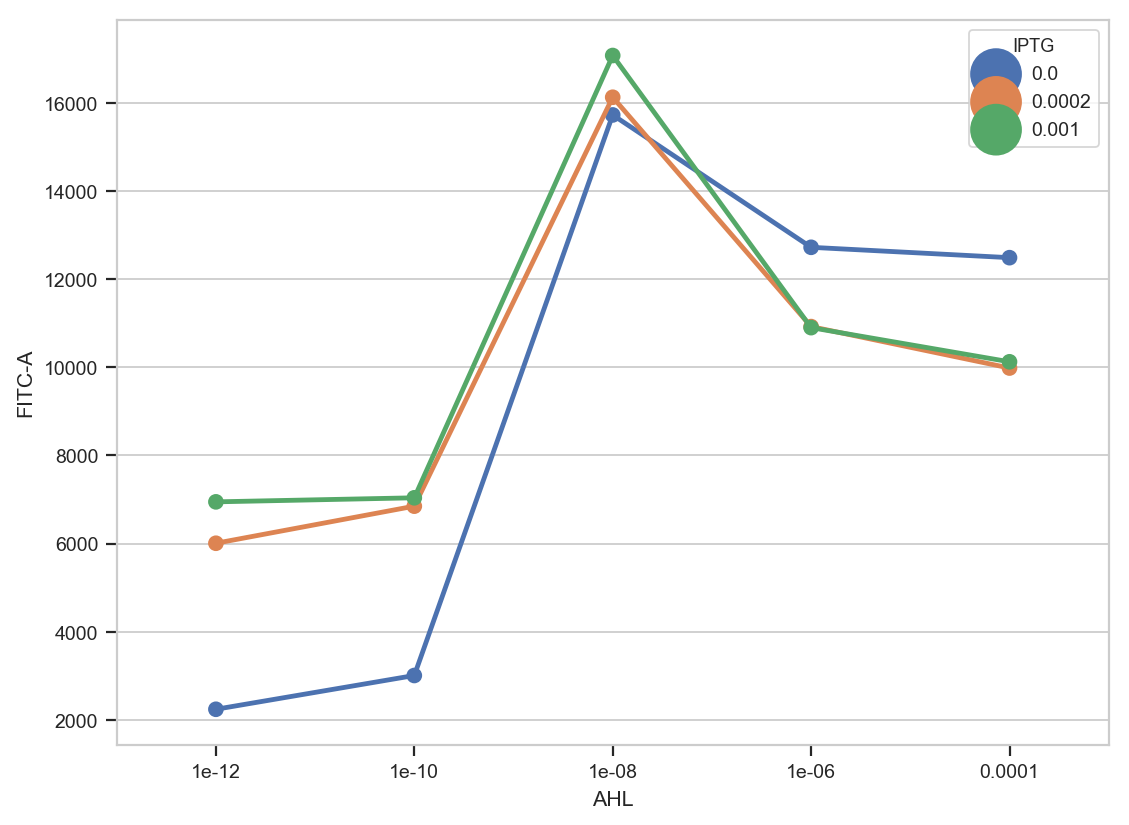

In [22]:
f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',estimator=gmean,ci=0.01,data=df)
f.savefig('Las.png',dpi=600)

In [23]:
mean

,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,2238.719403
1,1.000000e-12,0.0002,6006.957547
2,1.000000e-12,0.0010,6946.573536
3,1.000000e-10,0.0000,3005.608503
4,1.000000e-10,0.0002,6848.647498
5,1.000000e-10,0.0010,7038.514004
6,1.000000e-08,0.0000,15727.991336
7,1.000000e-08,0.0002,16129.576816
8,1.000000e-08,0.0010,17076.818567
9,1.000000e-06,0.0000,12723.731162


# Calculate standard deviation percentages

In [24]:
std['FITC-A']/mean['FITC-A']*100

0     202.367507
1     182.651933
2     178.692026
3     202.737634
4     172.720351
5     181.796267
6     253.037304
7     218.993835
8     203.132983
9     207.912921
10    261.023765
11    275.701356
12    226.641106
13    246.035167
14    255.895277
Name: FITC-A, dtype: float64

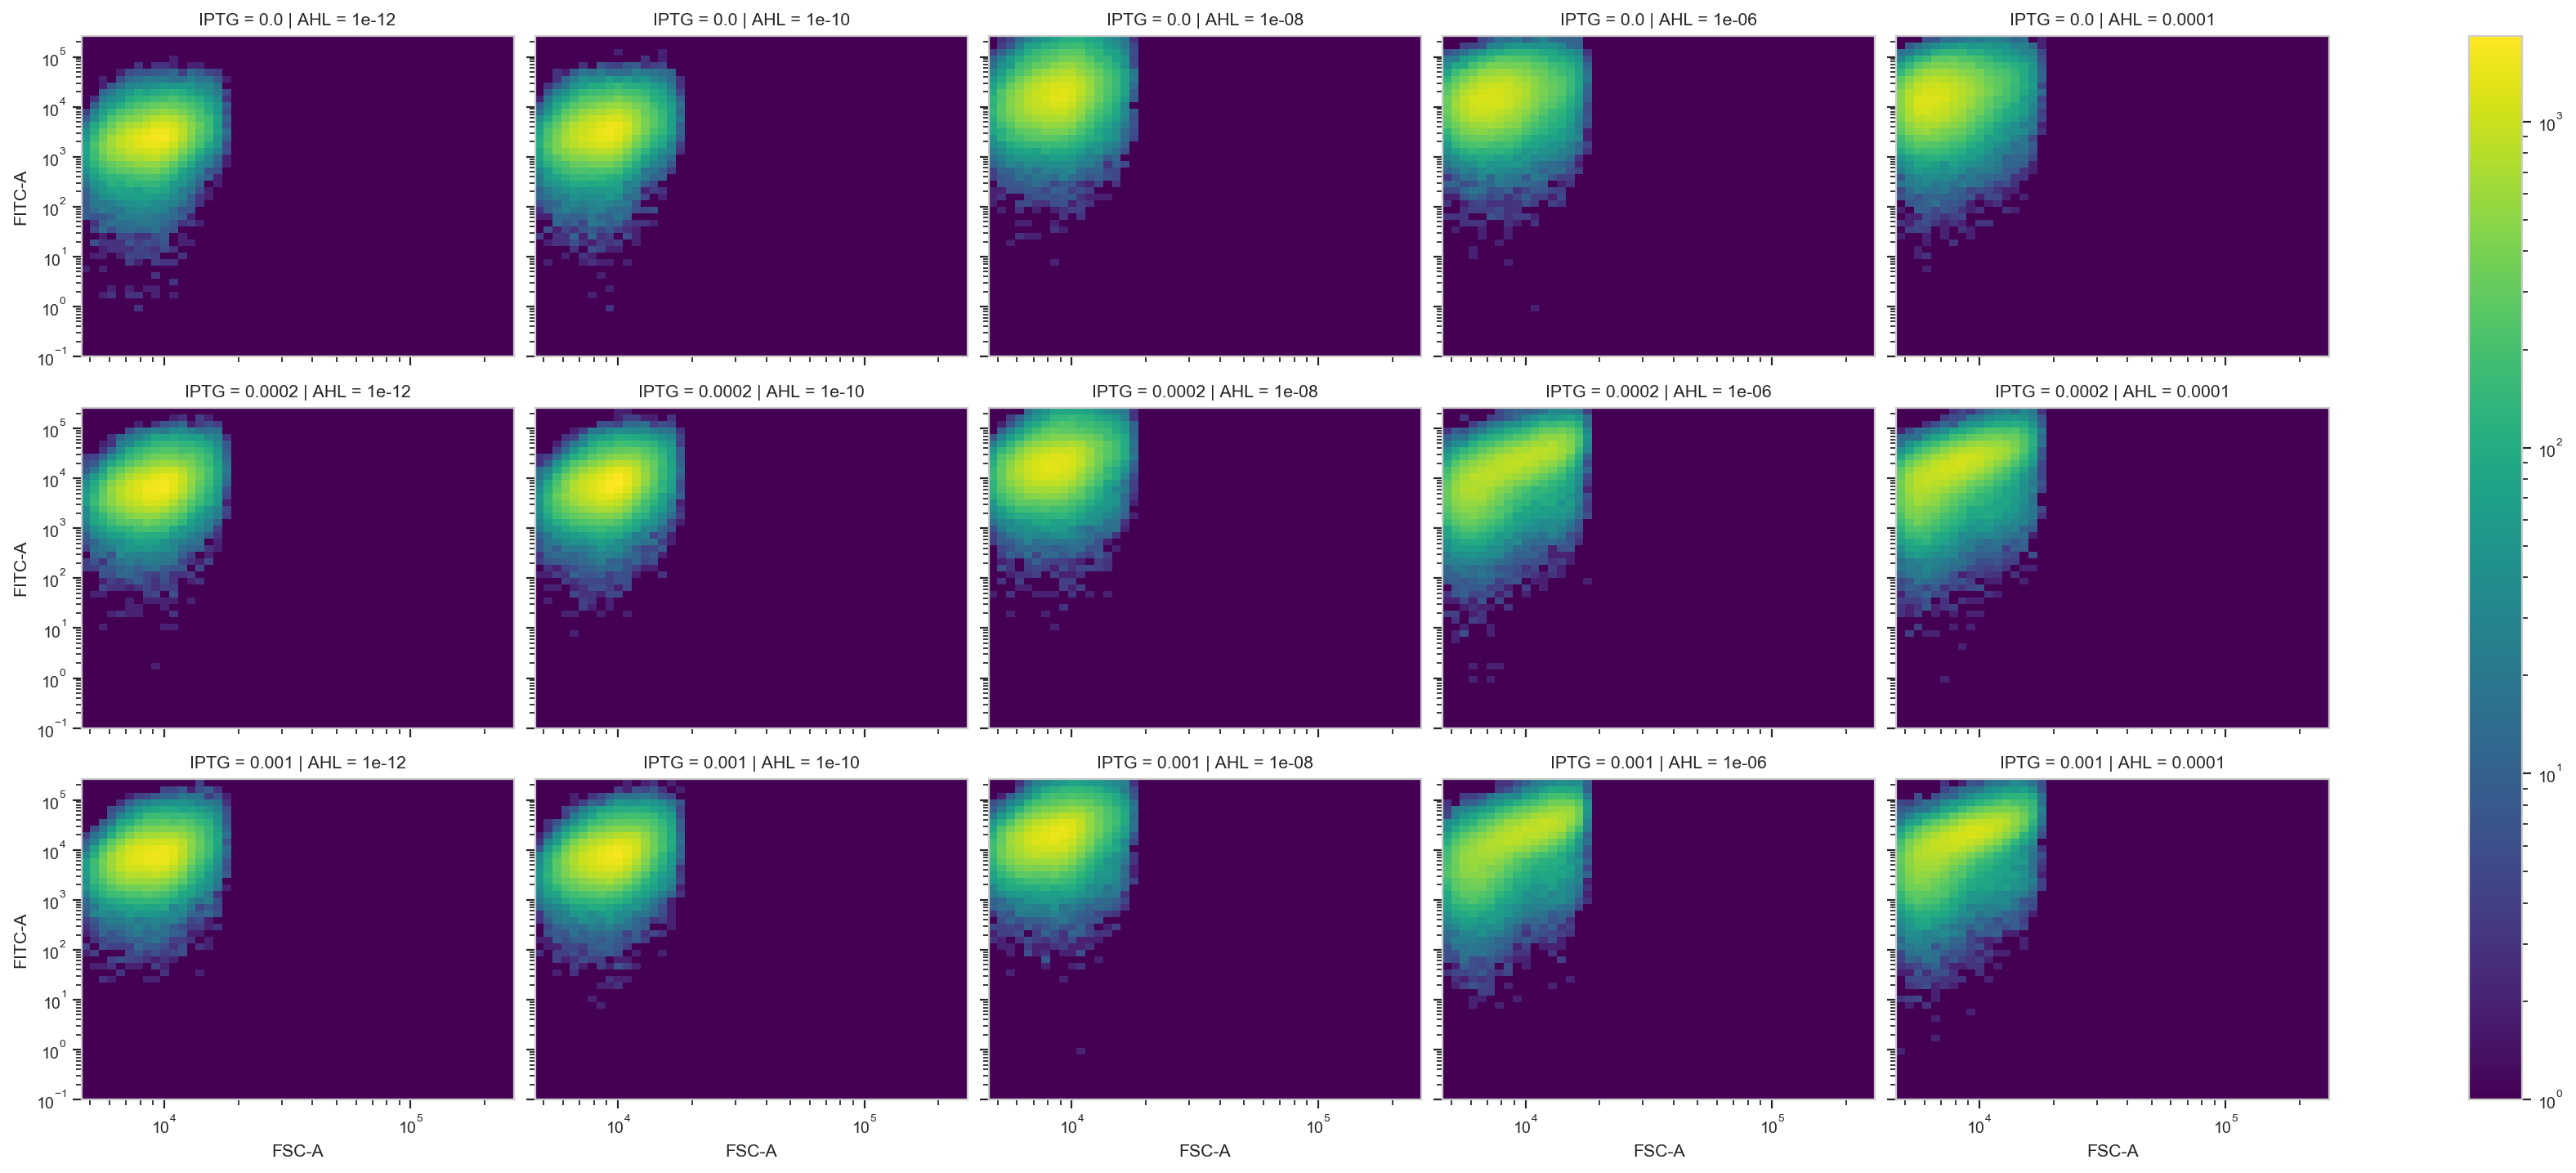

In [25]:

flow.DensityView(xchannel = 'FSC-A', 
                ychannel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'GM_1 == True').plot(ex_gm2, min_quantile = 0.01)

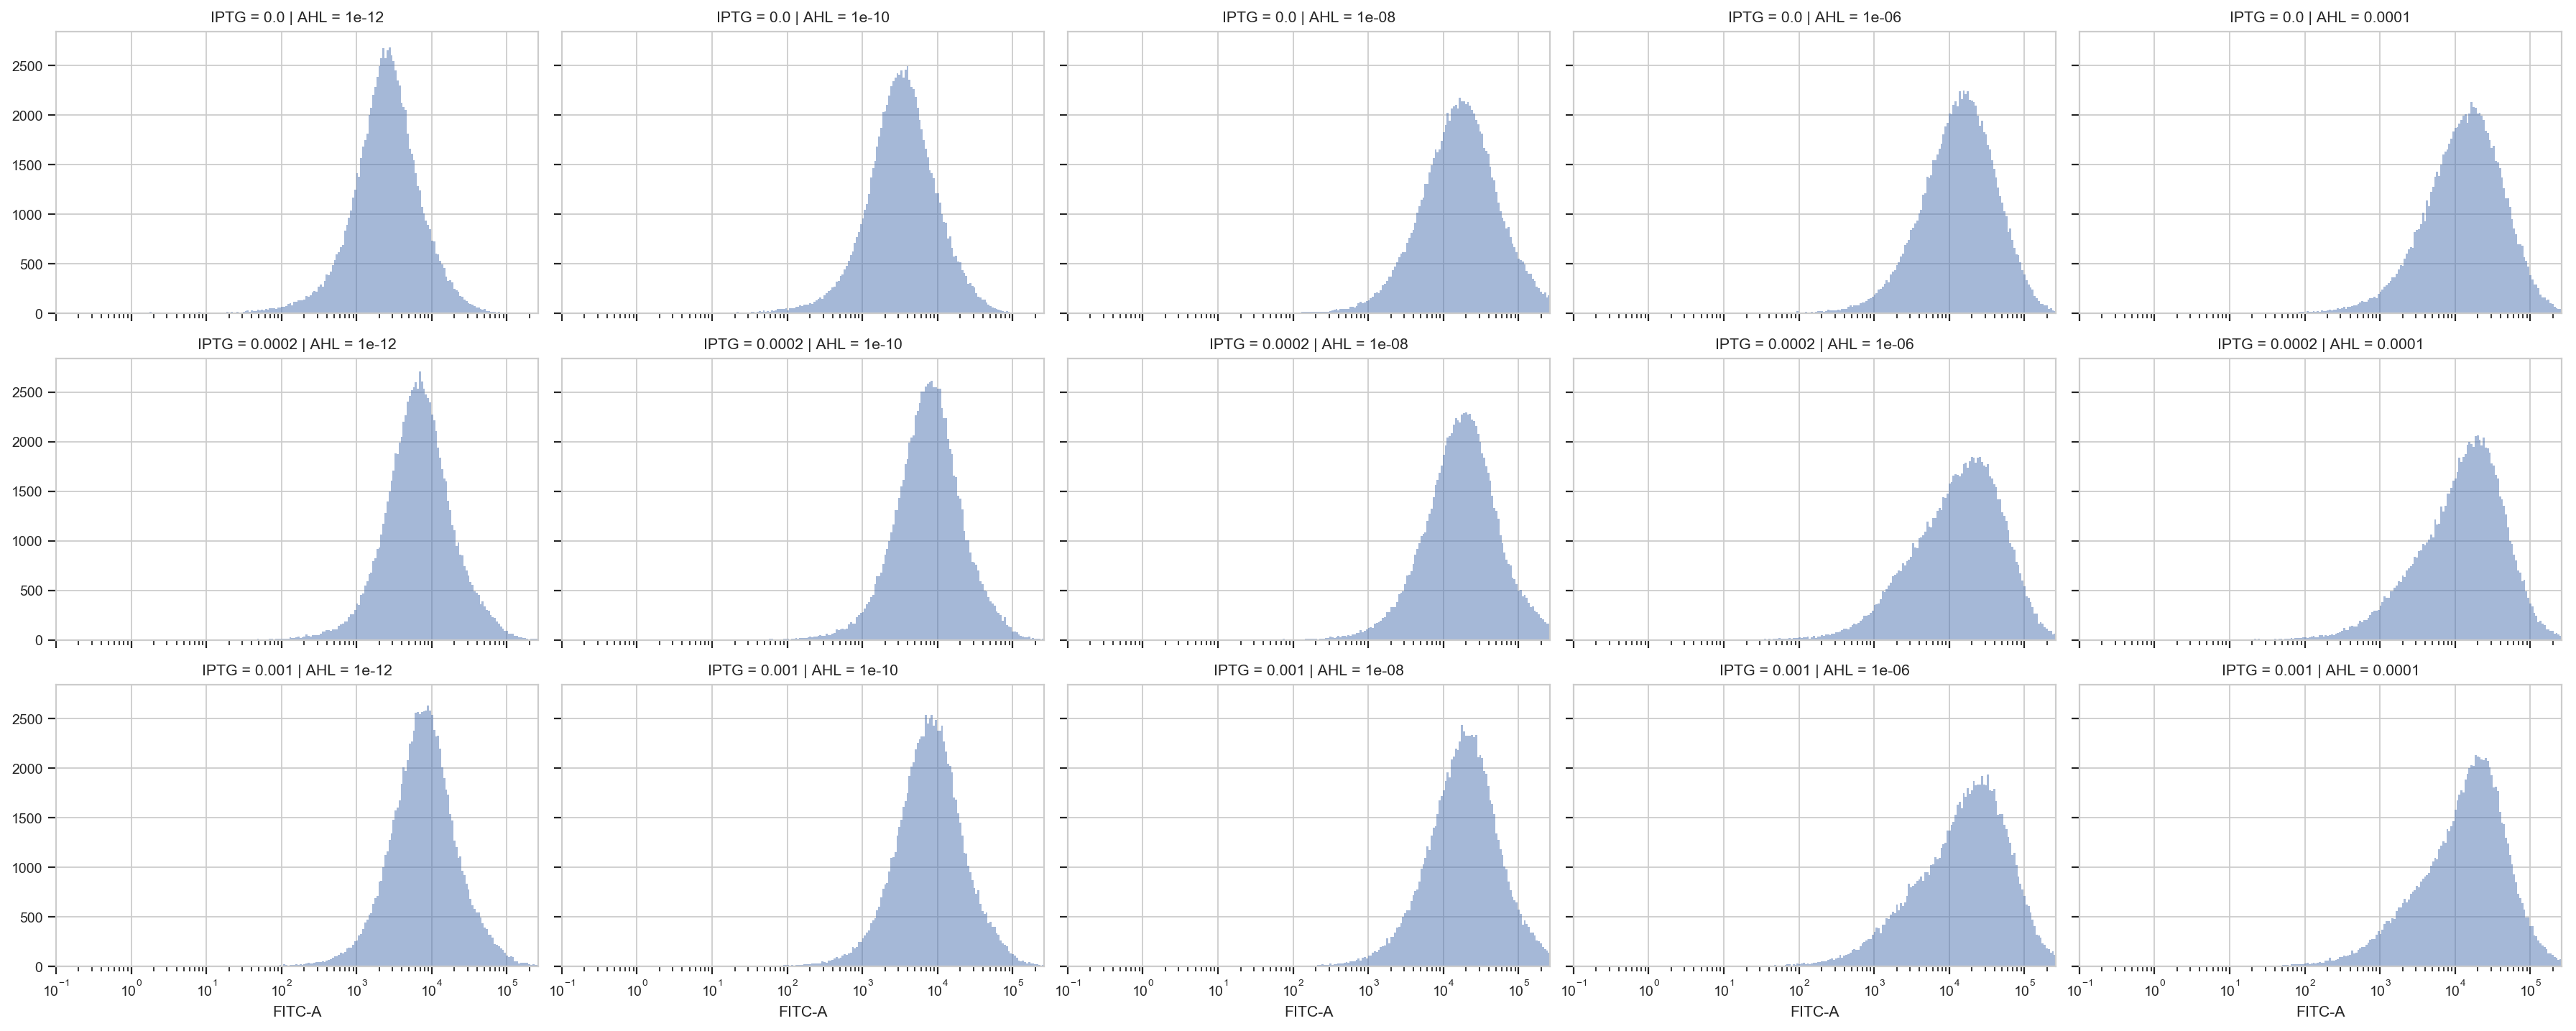

In [26]:
flow.HistogramView(channel = 'FITC-A',
                   xfacet = "AHL",
                yfacet='IPTG',
                 subset = 'Range2D == True').plot(ex_gm2, min_quantile = 0.01)

# Plot heatmaps showing absolute and relative induction

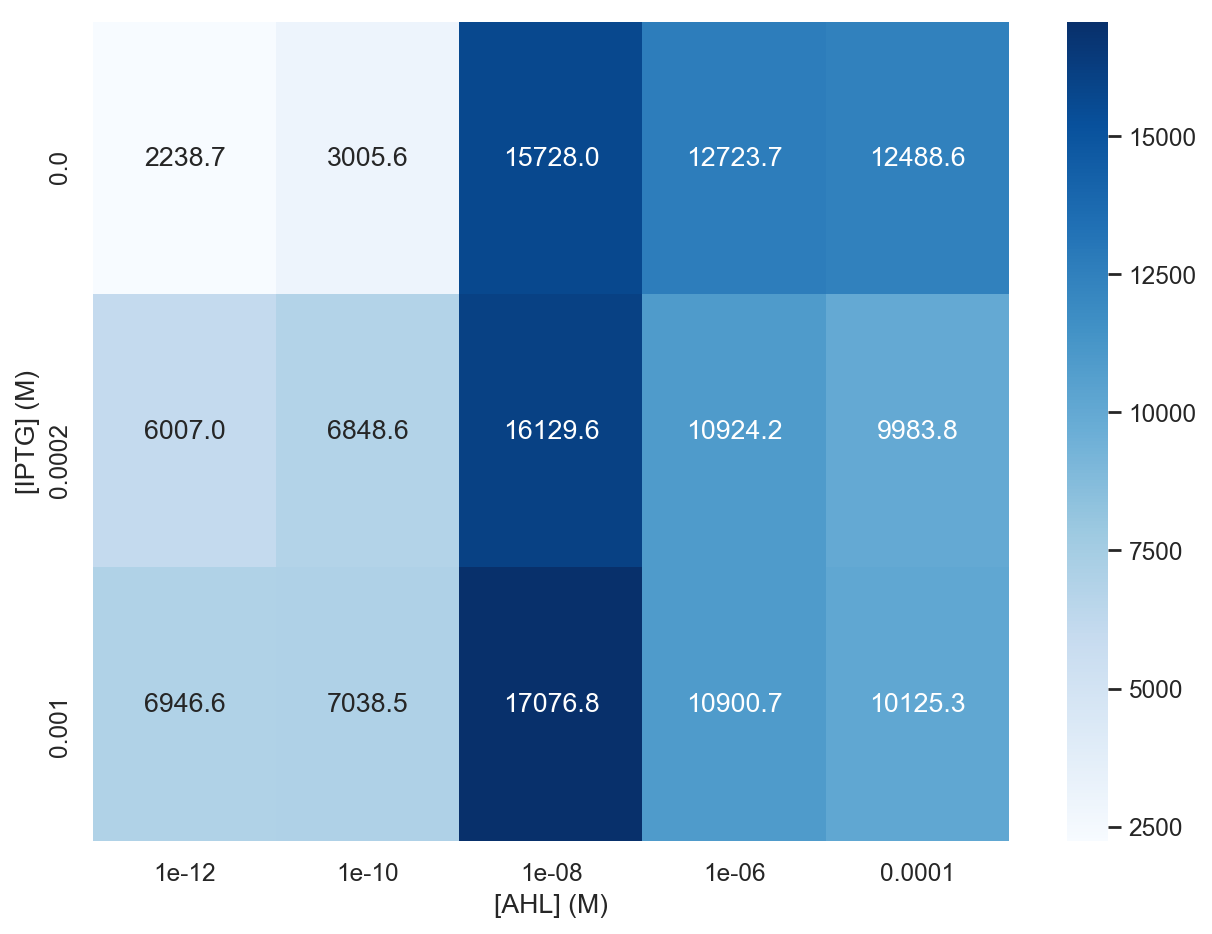

In [27]:
#LasMeans = Las.groupby(['C_ahl','C_iptg']).mean().reset_index()
sns.set(style="white")
#sns.set_style('Talk')
#LasTable = pd.pivot_table(LasMeans,values='FITC-A',index='C_iptg',columns='C_ahl')
f, ax = plt.subplots(figsize=(8,6))
#g = sns.heatmap(LasTable,vmin=0,vmax=100,xticklabels=[0,1e-10,1e-9,1e-7],yticklabels=[0,1e-3,1e-4,1e-5],ax=ax,square=True,cmap='Reds')



#f.savefig('LasHeatmap.png',dpi=600)
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
#mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

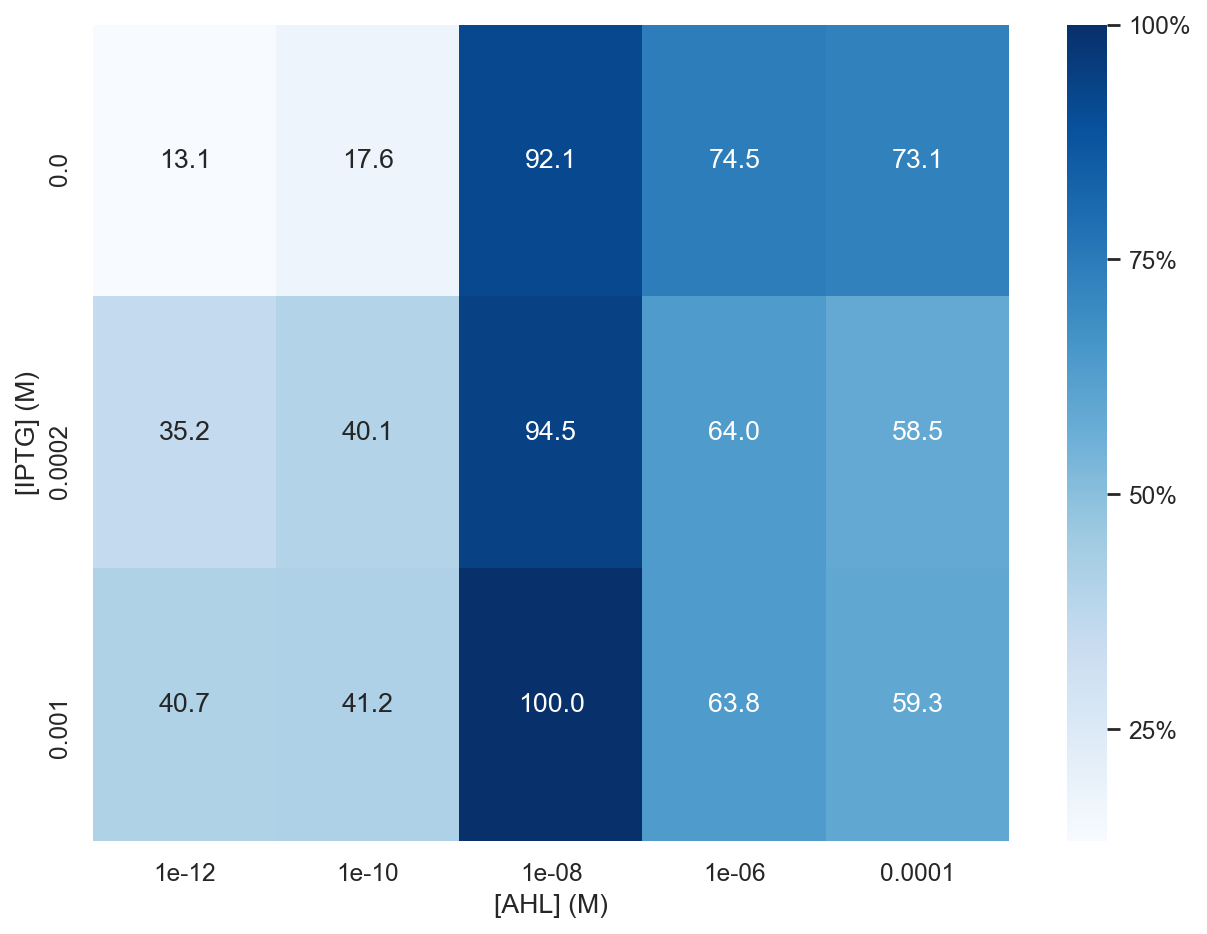

In [28]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mean.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [29]:

R =[]
for i in mean.IPTG.unique():
    tmp = mean[mean.IPTG ==i]['FITC-A'].max()/mean[mean.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [30]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.0000,7.025441
1,0.0002,2.685149
2,0.0010,2.458308


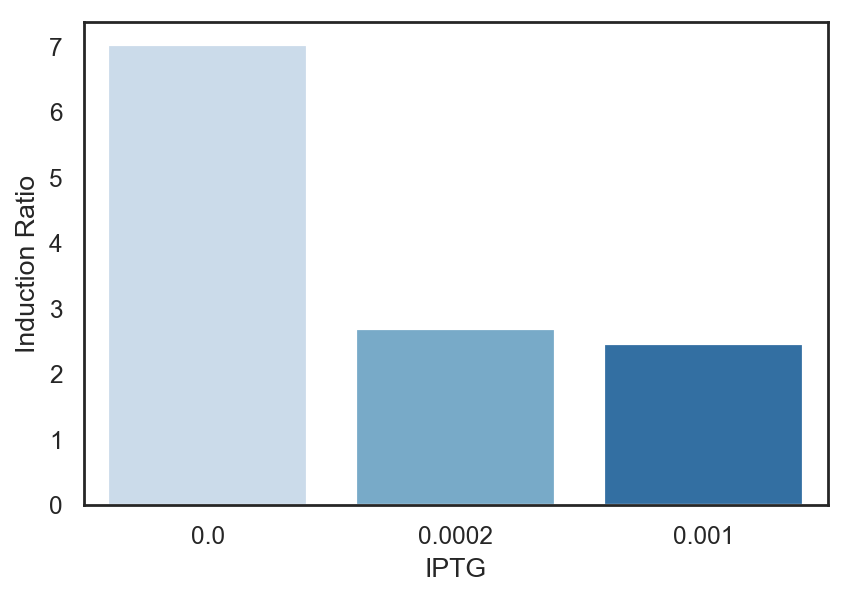

In [31]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

# Fit data to logistic function

In [32]:
import scipy.optimize as opt
mean = df.groupby(['AHL','IPTG'])['FITC-A'].apply(gmean).reset_index()
data = mean.copy()
data.AHL[data.AHL == 0]=1e-14


In [33]:
data

,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,2238.719403
1,1.000000e-12,0.0002,6006.957547
2,1.000000e-12,0.0010,6946.573536
3,1.000000e-10,0.0000,3005.608503
4,1.000000e-10,0.0002,6848.647498
5,1.000000e-10,0.0010,7038.514004
6,1.000000e-08,0.0000,15727.991336
7,1.000000e-08,0.0002,16129.576816
8,1.000000e-08,0.0010,17076.818567
9,1.000000e-06,0.0000,12723.731162


C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated


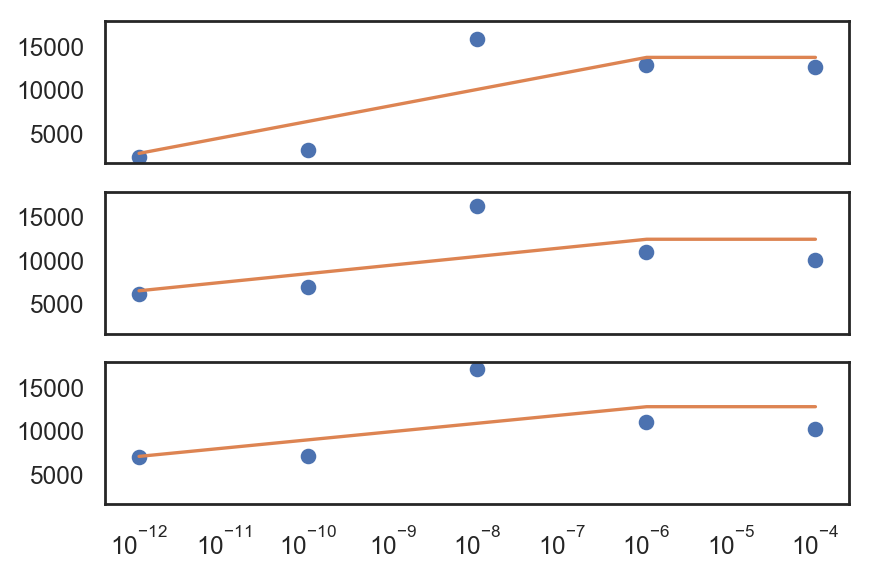

In [34]:
def f(x, a, b, c, d):
    return (a -b) / (1 + np.exp(c * (np.log10(d)-np.log10(x)))) + b
fig, axes = plt.subplots(3, 1, figsize=(6, 4),sharex=True,sharey=True)
axs = axes.ravel()
for i,iptg in enumerate(data.IPTG.unique()):
    tmp = data[data.IPTG==iptg]
    (a_, b_, c_, d_), _ = opt.curve_fit(f, tmp.AHL, tmp['FITC-A'],p0=[5e3,1e2,1e2,1e-9],maxfev=10000000)
    n = 100
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), n)

    y_fit = f(x, a_, b_, c_, d_)

    
    axs[i].plot(tmp.AHL.values, tmp['FITC-A'].values, 'o')
    axs[i].plot(x, y_fit, '-')
    plt.xscale('log')
plt.show()

In [35]:
tmp.AHL

2     1.000000e-12
5     1.000000e-10
8     1.000000e-08
11    1.000000e-06
14    1.000000e-04
Name: AHL, dtype: float64

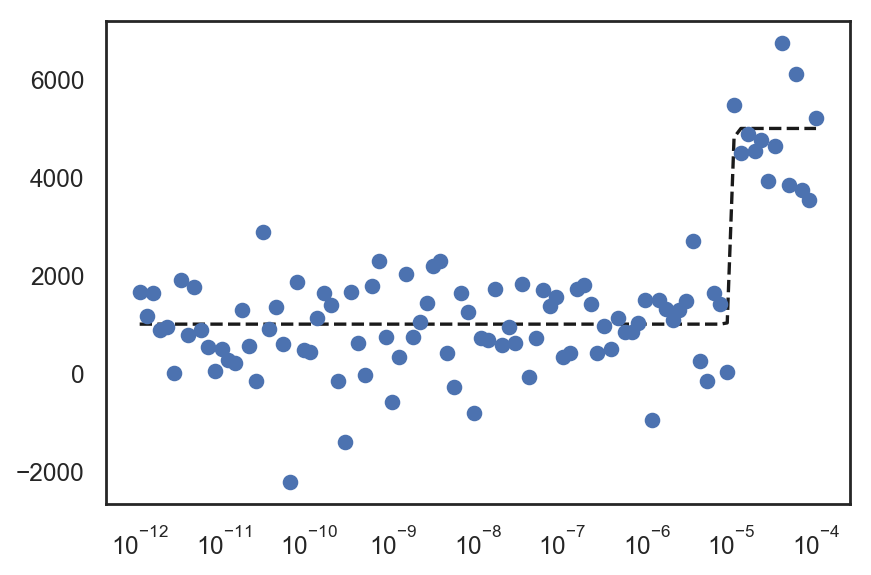

In [36]:
#a, c = np.random.exponential(size=2,scale=1e4)
#b, d = np.random.randn(2)
a,b,c,d = 5000,1000,1e2,1e-5
n = 100
#x = np.linspace(-12, -4, n)
x = np.logspace(-12,-4,n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)
#(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y,p0=[1e4,1,1,d])
#y_fit = f(x, a_, b_, c_, d_)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')
#ax.plot(x, y_fit, '-')
plt.xscale('log')



In [37]:
print(a_, b_, c_, d_)

12700.957917891708 6992.543770429515 100.0 1e-09


In [38]:
np.log10(0)

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10


-inf

In [39]:
x

array([1.00000000e-12, 1.20450354e-12, 1.45082878e-12, 1.74752840e-12,
       2.10490414e-12, 2.53536449e-12, 3.05385551e-12, 3.67837977e-12,
       4.43062146e-12, 5.33669923e-12, 6.42807312e-12, 7.74263683e-12,
       9.32603347e-12, 1.12332403e-11, 1.35304777e-11, 1.62975083e-11,
       1.96304065e-11, 2.36448941e-11, 2.84803587e-11, 3.43046929e-11,
       4.13201240e-11, 4.97702356e-11, 5.99484250e-11, 7.22080902e-11,
       8.69749003e-11, 1.04761575e-10, 1.26185688e-10, 1.51991108e-10,
       1.83073828e-10, 2.20513074e-10, 2.65608778e-10, 3.19926714e-10,
       3.85352859e-10, 4.64158883e-10, 5.59081018e-10, 6.73415066e-10,
       8.11130831e-10, 9.77009957e-10, 1.17681195e-09, 1.41747416e-09,
       1.70735265e-09, 2.05651231e-09, 2.47707636e-09, 2.98364724e-09,
       3.59381366e-09, 4.32876128e-09, 5.21400829e-09, 6.28029144e-09,
       7.56463328e-09, 9.11162756e-09, 1.09749877e-08, 1.32194115e-08,
       1.59228279e-08, 1.91791026e-08, 2.31012970e-08, 2.78255940e-08,
      

In [40]:
data


,AHL,IPTG,FITC-A
0,1.000000e-12,0.0000,2238.719403
1,1.000000e-12,0.0002,6006.957547
2,1.000000e-12,0.0010,6946.573536
3,1.000000e-10,0.0000,3005.608503
4,1.000000e-10,0.0002,6848.647498
5,1.000000e-10,0.0010,7038.514004
6,1.000000e-08,0.0000,15727.991336
7,1.000000e-08,0.0002,16129.576816
8,1.000000e-08,0.0010,17076.818567
9,1.000000e-06,0.0000,12723.731162


In [41]:
df.AHL.unique()

array([1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04])

In [42]:
df[df.AHL==1e-4]['FITC-A']

400000     77184.359375
400001      1807.589966
400003      8374.009766
400004     22292.718750
400005     50629.429688
400006     10978.149414
400007     27547.279297
400008     40059.789062
400010      9278.250000
400011     15458.410156
400012     26044.958984
400013      8407.830078
400014      2038.099976
400015     40834.980469
400016      6715.049805
400018     23225.439453
400020      7893.409668
400021     28207.660156
400023      1217.520020
400024     28104.419922
400025       831.260010
400026      9328.979492
400027      8883.979492
400029     23416.789062
400030     25383.689453
400031     40084.710938
400032     20988.869141
400034     14871.899414
400036     58465.878906
400039     11002.179688
               ...     
1499954    10990.609375
1499956    49415.468750
1499957     4475.810059
1499958    54859.597656
1499959     6945.560059
1499960     4012.119873
1499962    20556.330078
1499963     8462.120117
1499964    38068.859375
1499965    21789.869141
1499966     9331

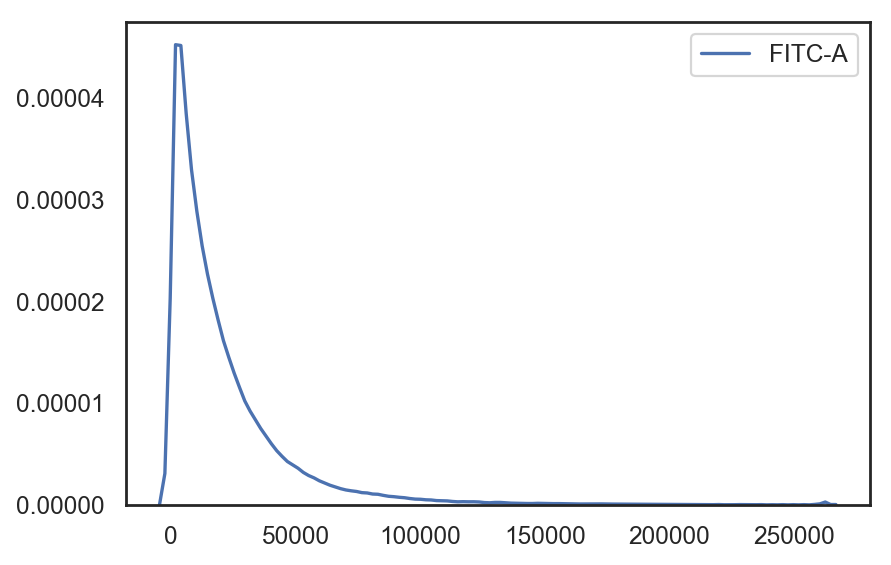

In [43]:
sns.kdeplot(df[df.AHL==1e-4]['FITC-A'])

C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
C:\Users\sakkosjo\Anaconda3\envs\cytoflow\lib\site-packages\matplotlib\tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


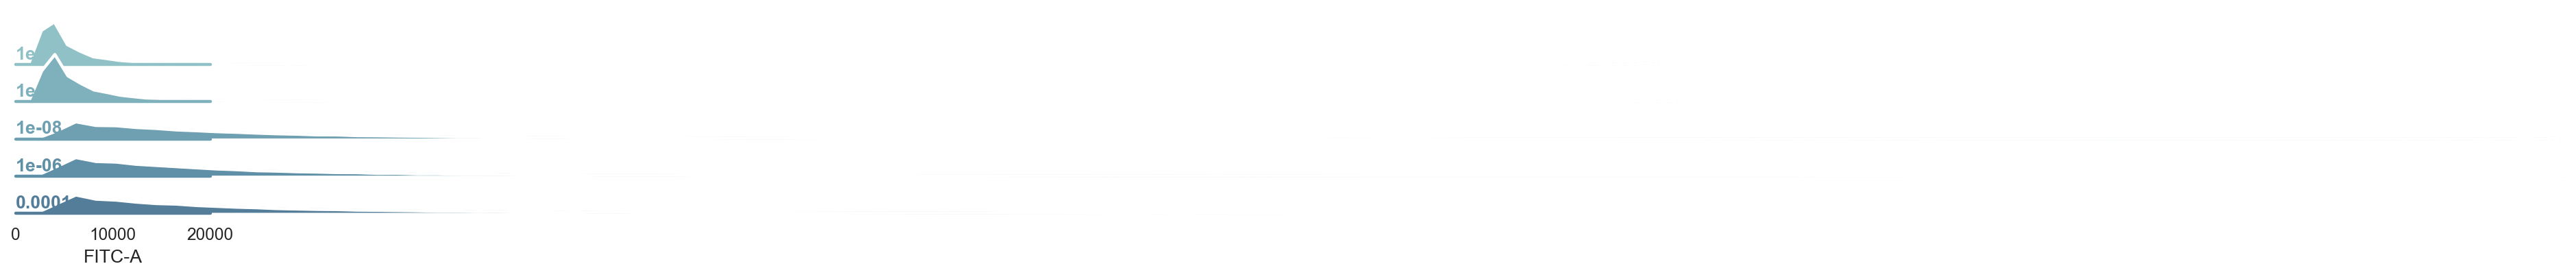

In [44]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
#rs = np.random.RandomState(1979)
#x = rs.randn(500)
#g = np.tile(list("ABCDEFGHIJ"), 50)
#df = pd.DataFrame(dict(x=x, g=g))
#m = df.g.map(ord)
#df["x"] += m
tmpdf = df[df.IPTG==0][['AHL','FITC-A']]
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(tmpdf, row="AHL", hue="AHL", aspect=5, height=0.5, palette=pal)
g.set(xlim=(0, 20000))
# Draw the densities in a few steps
g.map(sns.kdeplot, "FITC-A", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "FITC-A", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "FITC-A")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

